MIT License

Copyright (c) 2021 Priyanka Dilip Shinde

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

**Abstract**

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined.

Aim: To build a predictive model and predict the sales of each product at a particular outlet.



---



Variable	Description

Item_Identifier:	Unique product ID

Item_Weight:	Weight of product

Item_Fat_Content:	Whether the product is low fat or not

Item_Visibility:	The % of total display area of all products in a store 
allocated to the particular product

Item_Type:	The category to which the product belongs

Item_MRP:	Maximum Retail Price (list price) of the product

Outlet_Identifier:	Unique store ID

Outlet_Establishment_Year:	The year in which store was established

Outlet_Size:	The size of the store in terms of ground area covered

Outlet_Location_Type:	The type of city in which the store is located

Outlet_Type:	Whether the outlet is just a grocery store or some sort of supermarket

Item_Outlet_Sales:	Sales of the product in the particular store. This is the outcome variable to be predicted.



---



Loaded required libraries and train and test dataset. Performed Exploratory 
Data Analysis using pandas profiling to understand the data. Imputed missing values in attributes Item_Weight and Outlet_Size. Modified Item_Visibility, Item_Fat_Content to make sense. Created new features Outlet_Years, Outlet_Age and Item_Type_Combined. Encoded Categorical data. Used TPOT Automl to give best pipeline. Compared performance of two regression models and found ExtraTreeRegressor giving a better score. Performed Hyperparameter Tuning on ExtraTreeRegressor to give better score. Achieved rmse score of 1148.12 on test dataset.

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


In [ ]:
!pip install -q shap

In [ ]:
!pip install tpot

# Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
import seaborn as sns
from scipy.stats import mode
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFwe
from sklearn.linear_model import SGDRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
train = pd.read_csv("https://raw.githubusercontent.com/priyankads/Big-Mart-Sales-Prediction/main/traindata.csv")
train.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
test = pd.read_csv("https://raw.githubusercontent.com/priyankads/Big-Mart-Sales-Prediction/main/testdata.csv")
test.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


# Exploratory Data Analysis 

In [ ]:
profile = ProfileReport(train, title = "Big Market Sales Dataset", html = {'style': {'full width': True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f54818c5b50>,
      dtype=object)

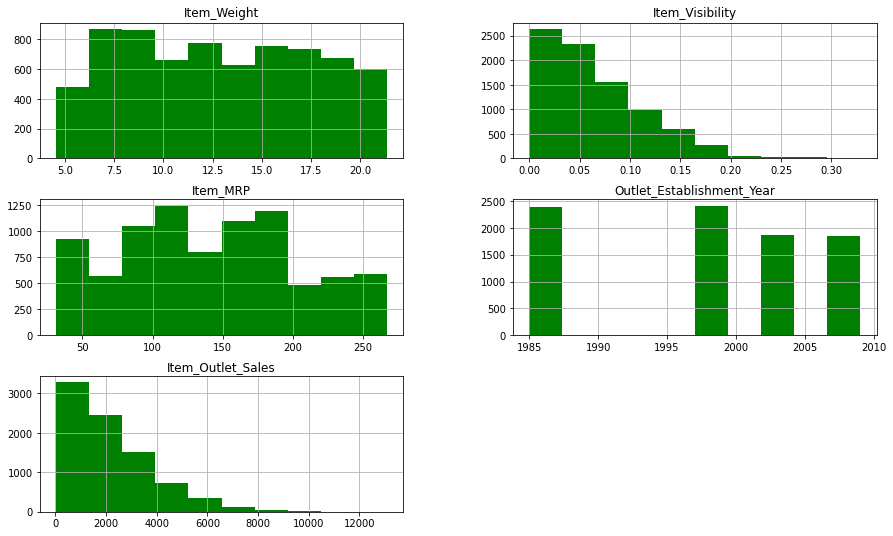

In [ ]:
train.hist(color = 'green', figsize=(15, 9))

**Impact of Outlet_Size on Item_Outlet_Sales**

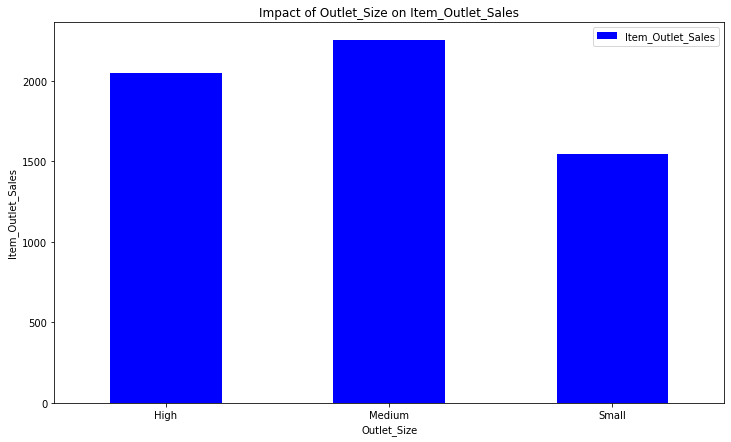

In [ ]:
Outlet_Size_pivot = train.pivot_table(index="Outlet_Size", values="Item_Outlet_Sales", aggfunc=np.median)
Outlet_Size_pivot.plot(kind='bar', color='blue',figsize=(12,7))

plt.xlabel("Outlet_Size")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Size on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

Medium outlet size have the higher sales than the High and Small outlet size.


**Impact of Outlet_Type on Item_Outlet_Sales**

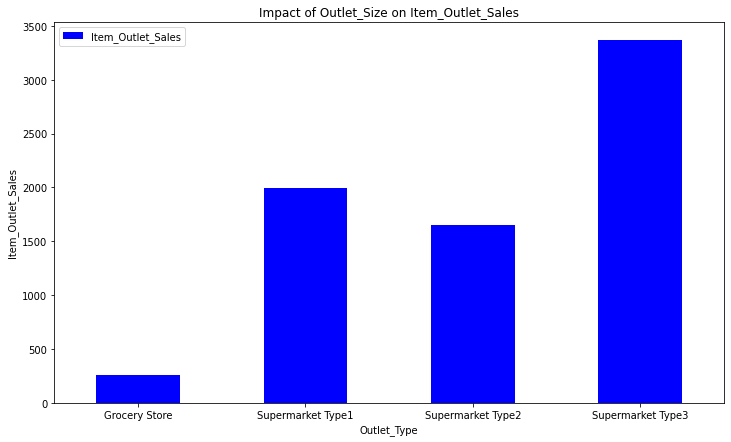

In [ ]:
Outlet_Type_pivot = train.pivot_table(index="Outlet_Type", values="Item_Outlet_Sales", aggfunc=np.median)
Outlet_Type_pivot.plot(kind='bar', color='blue',figsize=(12,7))

plt.xlabel("Outlet_Type")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Size on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

Supermarket Type3 have the higher sales than the other outlet types.


**Impact of Outlet_Location_Type on Item_Outlet_Sales**

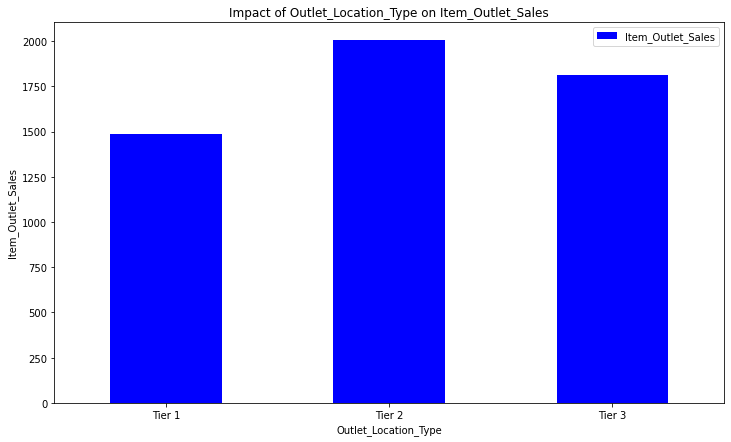

In [ ]:
Outlet_Location_Type_pivot = train.pivot_table(index="Outlet_Location_Type", values="Item_Outlet_Sales", aggfunc=np.median)
Outlet_Location_Type_pivot.plot(kind='bar', color='blue',figsize=(12,7))

plt.xlabel("Outlet_Location_Type")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Location_Type on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()


Tier 2 cities have the higher sales than the Tier 1 and Tier 3.


# Data Checking

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Summary of train Dataset:
*   There are total 8523 observations and 12 predictors.
*   Attributes Item_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, Outlet_Type are categorical variables.
*   Attributes Item_Weight and Outlet_Size have missing values.






In [ ]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Feature Item_Visibility has min value 0 which does not makes sense and needs to be imputed.

In [ ]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [ ]:
train.isnull().sum() / len(train) * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [ ]:
train.Item_Weight.value_counts()

12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.560      2
9.420      1
5.400      1
6.520      1
7.685      1
Name: Item_Weight, Length: 415, dtype: int64

Imputing missing values in Item_Weight by mean.

In [ ]:
train['Item_Weight'] = train['Item_Weight'].fillna(np.mean(train['Item_Weight']))

In [ ]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
train.Outlet_Size.value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

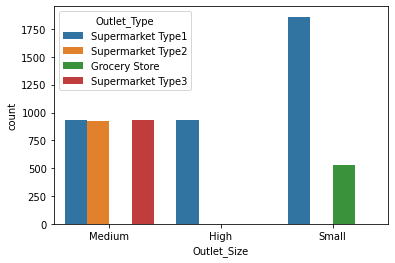

In [ ]:
sns.countplot('Outlet_Size',hue='Outlet_Type',data=train)

Imputing missing values in Outlet_Size with the mode of the Outlet_Size for the particular type of outlet.

In [ ]:
outlet_size_mode = train.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print('Mode for each Outlet_Type:\n',outlet_size_mode)

Mode for each Outlet_Type:
 Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3
Outlet_Size         Small             Small            Medium            Medium


In [ ]:
miss_bool = train['Outlet_Size'].isnull()

In [ ]:
train.loc[miss_bool,'Outlet_Size'] = train.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

Imputing 0 values in Item_Visibility by considering it like missing information and replacing it with mean visibility of that product.

In [ ]:
(train[['Item_Visibility']] == 0).sum()

Item_Visibility    526
dtype: int64

In [ ]:
train['Item_Visibility'] = train['Item_Visibility'].replace(0,train['Item_Visibility'].mean())

# Feature Engineering 

Creating a new feature Outlet_Age from Outlet_Establishment_Year which gives age of the outlet as compared to other outlets.

In [ ]:
train['Outlet_Age']= train['Outlet_Establishment_Year'] - (train['Outlet_Establishment_Year'].min()-1)

Creating new feature Outlet_Years from Outlet_Establishment_Year which gives information of the number of years the outlet existed from when it was established, till 2013.

In [ ]:
train['Outlet_Years'] = 2013 - train['Outlet_Establishment_Year']

If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. Creating a new feature Item_Type_Combined by using Item_Identifier.

In [ ]:
train['Item_Type_Combined'] = train['Item_Identifier'].apply(lambda x: x[0:2])
train['Item_Type_Combined'] = train['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})

Modifying categories of Item_Fat_Content to make sense.

In [ ]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [ ]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})

there were some non-consumables where fat-content is specified for them which does not make sense. So create a separate category for such kind of observations.

In [ ]:
train.loc[train['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"

Encoding Categorical Variables using Label Encoding and One-Hot Encoding.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['Outlet'] = le.fit_transform(train['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type', 'Outlet']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])

In [ ]:
train = pd.get_dummies(train, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type', 'Item_Type_Combined', 'Outlet',  'Item_Type'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  8523 non-null   object 
 1   Item_Weight                      8523 non-null   float64
 2   Item_Visibility                  8523 non-null   float64
 3   Item_MRP                         8523 non-null   float64
 4   Outlet_Identifier                8523 non-null   object 
 5   Outlet_Establishment_Year        8523 non-null   int64  
 6   Item_Outlet_Sales                8523 non-null   float64
 7   Outlet_Age                       8523 non-null   int64  
 8   Outlet_Years                     8523 non-null   int64  
 9   Item_Fat_Content_0               8523 non-null   uint8  
 10  Item_Fat_Content_1               8523 non-null   uint8  
 11  Item_Fat_Content_2               8523 non-null   uint8  
 12  Outlet_Location_Type

Correlation between different features using Heatmap.

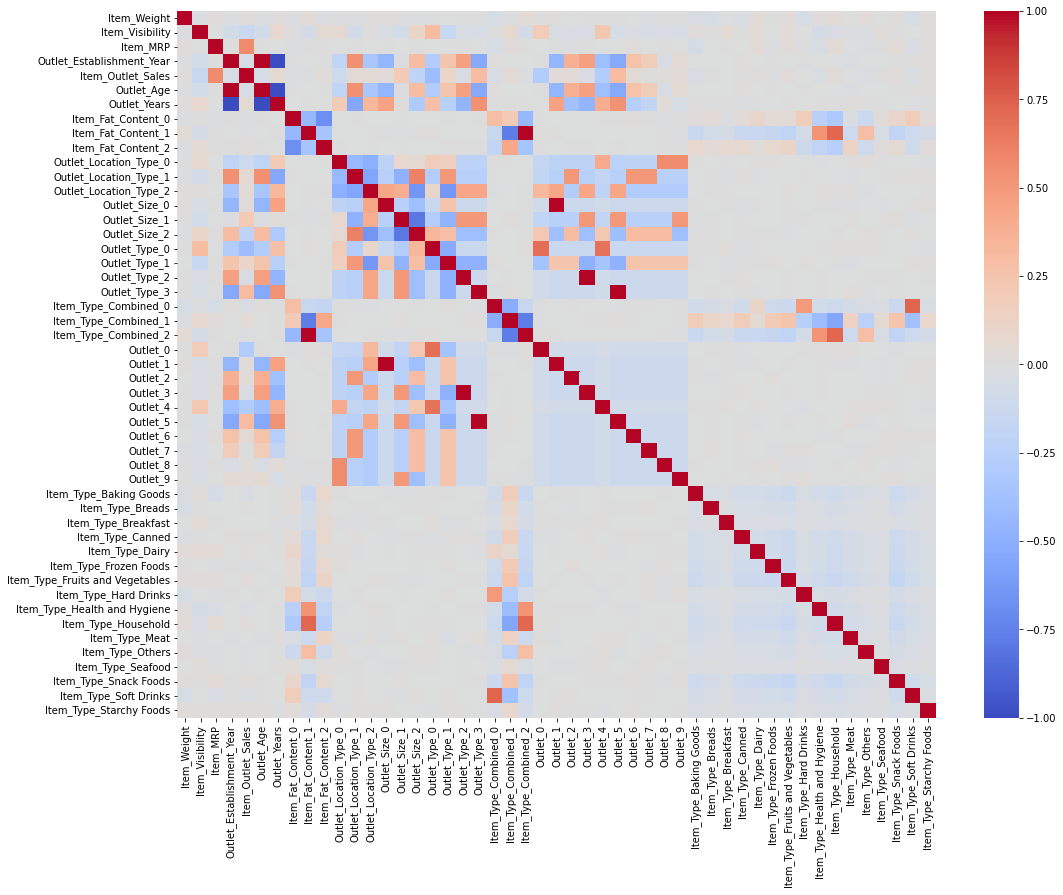

In [ ]:
plt.figure(figsize=(17, 13))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False) 

When there is no correlation between 2 variables (when correlation is 0 or near 0) the color is gray. The darkest red means there is a perfect positive correlation, while the darkest blue means there is a perfect negative correlation. For Example:

*   Outlet_Age and Outlet_Establishment_Year have perfect positive correlation.
*   Outlet_Years and Outlet_Establishment_Year have perfect negative correlation.

In [ ]:
corr = train.corr()
corr['Item_Outlet_Sales'].sort_values(ascending=False)

Item_Outlet_Sales                  1.000000
Item_MRP                           0.567574
Outlet_5                           0.311192
Outlet_Type_3                      0.311192
Outlet_Size_1                      0.204701
Outlet_Type_1                      0.108765
Outlet_Location_Type_1             0.058261
Outlet_6                           0.052823
Outlet_Years                       0.049135
Outlet_Location_Type_2             0.046376
Outlet_9                           0.034264
Outlet_2                           0.032610
Item_Type_Combined_1               0.031905
Item_Type_Fruits and Vegetables    0.025950
Outlet_Size_0                      0.024170
Outlet_1                           0.024170
Item_Type_Snack Foods              0.022782
Outlet_8                           0.019803
Item_Fat_Content_2                 0.018719
Item_Type_Household                0.015701
Item_Type_Starchy Foods            0.015039
Item_Weight                        0.011550
Item_Type_Dairy                 

Correlation of each predictor with traget variable Item_Outlet_Sales.

# Splitting the data into training and validation dataset.

In [ ]:
X = train.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales', 'Outlet_Establishment_Year'], axis = 1)   
y = train.Item_Outlet_Sales  

In [ ]:
y=y.astype('int')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Using TPOT Automl to find best pipeline steps.

In [ ]:
# from tpot import TPOTRegressor
# #from sklearn.metrics import f1_score

# # Instantiate TPOTRegressor
# tpot = TPOTRegressor(
#     generations=10,
#     population_size=20,
#     verbosity=2,
#     #scoring='MSE',
#     random_state=42,
#     disable_update_check=True,
    
# )
# tpot.fit(X_train, y_train)


# # Print best pipeline steps
# print('\nBest pipeline steps:', end='\n')
# for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
#     # Print idx and transform
#     print(f'{idx}. {transform}')

# Model Building and Optimization

we’ll optimize min_samples_leaf each time till the score stops improving.

**Hyperparameter Tuning 1**

In [ ]:
regressor = ExtraTreesRegressor(bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=13, min_samples_split=15, n_estimators=100)

In [ ]:
regressor.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.8500000000000001,
                    max_leaf_nodes=None, max_samples=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=13, min_samples_split=15,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [ ]:
test_data_prediction = regressor.predict(X_test)

In [ ]:
mse_test = metrics.mean_squared_error(y_test, test_data_prediction)
rmse = np.sqrt(mse_test)

In [ ]:
print('Root Mean Squared Error = ', rmse)

Root Mean Squared Error =  1056.4053590061671


**Hyperparameter Tuning 2**

In [ ]:
regressor1 = ExtraTreesRegressor(bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=15, min_samples_split=15, n_estimators=100)

In [ ]:
regressor1.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.8500000000000001,
                    max_leaf_nodes=None, max_samples=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=15, min_samples_split=15,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [ ]:
test_data_prediction1 = regressor1.predict(X_test)

In [ ]:
mse_test3 = metrics.mean_squared_error(y_test, test_data_prediction1)
rmse3 = np.sqrt(mse_test3)
rmse3

1055.2579044794609

**Hyperparameter Tuning 3**

In [ ]:
regressor2 = ExtraTreesRegressor(bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=16, min_samples_split=15, n_estimators=100)

In [ ]:
regressor2.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.8500000000000001,
                    max_leaf_nodes=None, max_samples=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=16, min_samples_split=15,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [ ]:
test_data_prediction2 = regressor2.predict(X_test)

In [ ]:
mse_test4 = metrics.mean_squared_error(y_test, test_data_prediction2)
rmse4 = np.sqrt(mse_test4)
rmse4

1053.5874792703687

**Hyperparameter Tuning 4**

In [ ]:
regressor3 = ExtraTreesRegressor(bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=17, min_samples_split=15, n_estimators=100)

In [ ]:
regressor3.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.8500000000000001,
                    max_leaf_nodes=None, max_samples=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=17, min_samples_split=15,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [ ]:
test_data_prediction3 = regressor3.predict(X_test)

In [ ]:
mse_test5 = metrics.mean_squared_error(y_test, test_data_prediction3)
rmse5 = np.sqrt(mse_test5)
rmse5

1054.3958837355422

In Hyperparameter Tuning 4 the rmse score stops improving so we will stop at Hyperparameter Tuning 3.

Fitting Different Model

In [ ]:
model1 = GradientBoostingRegressor(alpha=0.999, criterion='friedman_mse', init=None,
                          learning_rate=0.061, loss='huber', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=90,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
model1.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.999, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.061, loss='huber',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=90,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
prediction_new = model1.predict(X_test)

In [ ]:
mse_test2 = metrics.mean_squared_error(y_test, prediction_new)
rmse2 = np.sqrt(mse_test2)

In [ ]:
print('Root Mean Squared Error = ', rmse2)

Root Mean Squared Error =  1053.3894840454857


rmse score is not as good as ExtraTreeRegressor.

# Feature Importance 

comparing the importance of the variables computed with SHAP values versus Extra Tree Regressor.

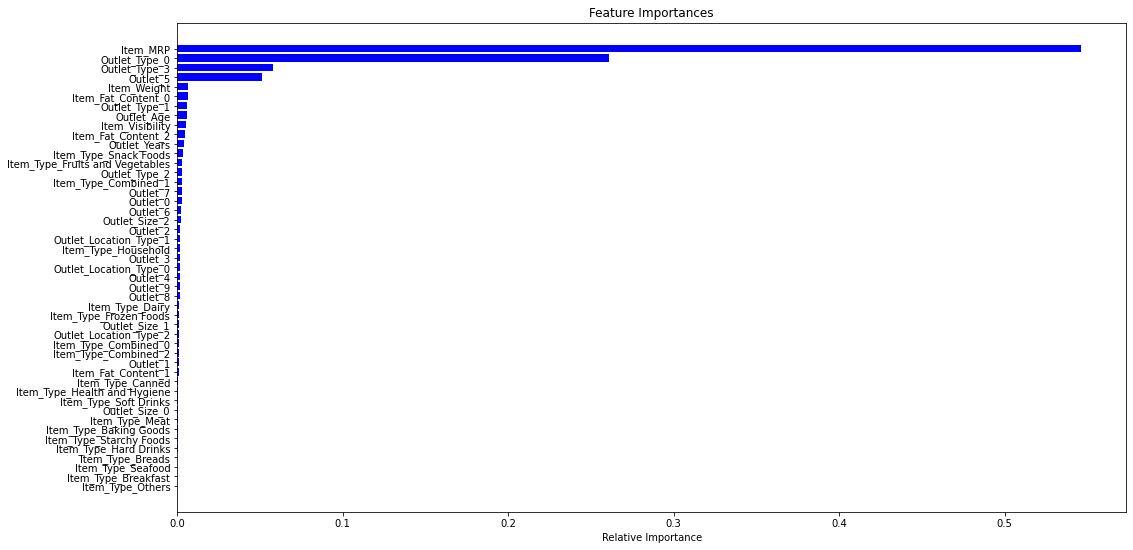

In [ ]:
importances = regressor.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(17, 9))
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
import shap


explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train,approximate=False, check_additivity=False)

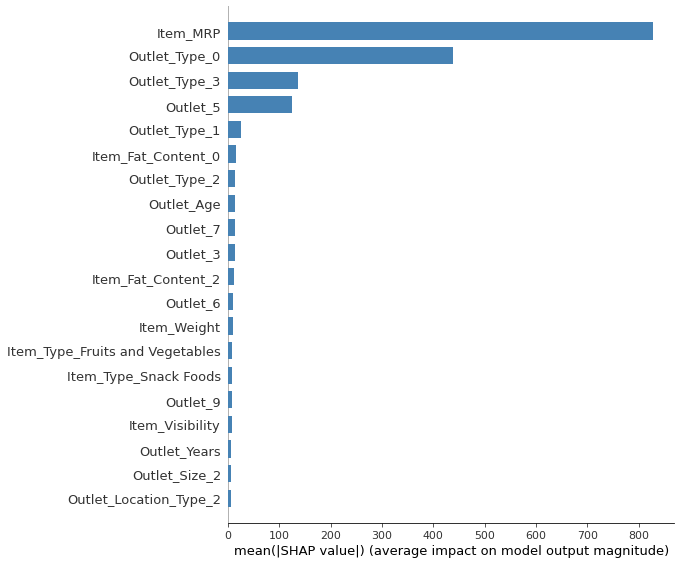

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar", color='steelblue')

The actual importances of each feature that are given by the two methods are similar but not identical. The Item_Weight comes before Outlet_Type_1 according to Extra Tree Regressor, while SHAP tells the contrary. 

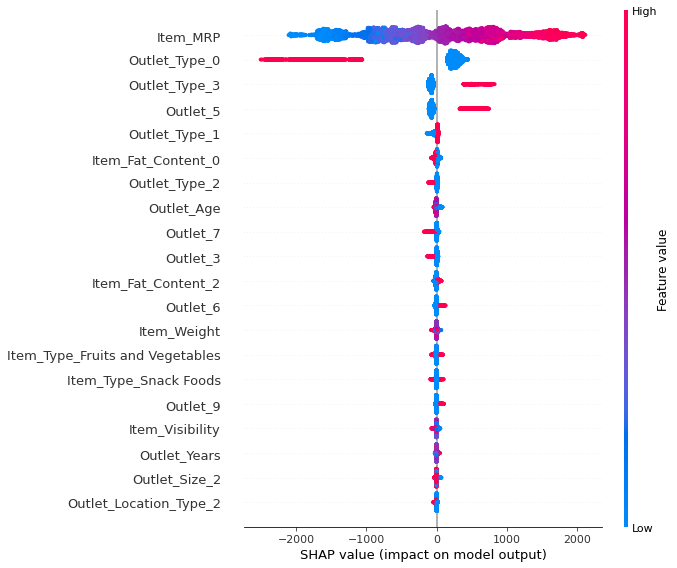

In [ ]:
shap.summary_plot(shap_values, X_train)

# Test Dataset

Performing Data Cleaning and Feature Engineering on test dataset to make it ready to be fed in model for prediction.

In [ ]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [ ]:
test['Item_Weight'] = test['Item_Weight'].fillna(np.mean(test['Item_Weight']))

In [ ]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [ ]:
outlet_size_mode = test.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print('Mode for each Outlet_Type:\n',outlet_size_mode)

miss_bool = test['Outlet_Size'].isnull()

test.loc[miss_bool,'Outlet_Size'] = test.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

Mode for each Outlet_Type:
 Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3
Outlet_Size         Small             Small            Medium            Medium


In [ ]:
(test[['Item_Visibility']] == 0).sum()

Item_Visibility    353
dtype: int64

In [ ]:
test['Item_Visibility'] = test['Item_Visibility'].replace(0,test['Item_Visibility'].mean())

In [ ]:
test['Outlet_Age']= test['Outlet_Establishment_Year'] - (test['Outlet_Establishment_Year'].min()-1)

In [ ]:
test['Outlet_Years'] = 2013 - test['Outlet_Establishment_Year']

In [ ]:
test['Item_Type_Combined'] = test['Item_Identifier'].apply(lambda x: x[0:2])
test['Item_Type_Combined'] = test['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable', 
                                                             'DR':'Drinks'})

In [ ]:
test['Item_Fat_Content'].unique()

array(['Low Fat', 'reg', 'Regular', 'LF', 'low fat'], dtype=object)

In [ ]:
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})

In [ ]:
test.loc[test['Item_Type_Combined'] == "Non-Consumable",'Item_Fat_Content'] = "Non-Edible"

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test['Outlet'] = le.fit_transform(test['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type', 'Outlet']
le = LabelEncoder()
for i in var_mod:
    test[i] = le.fit_transform(test[i])

In [ ]:
test = pd.get_dummies(test, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type', 'Item_Type_Combined', 'Outlet',  'Item_Type'])

In [ ]:
test_new = test.drop(['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'], axis = 1)

In [ ]:
test_new.isnull().sum()

Item_Weight                        0
Item_Visibility                    0
Item_MRP                           0
Outlet_Age                         0
Outlet_Years                       0
Item_Fat_Content_0                 0
Item_Fat_Content_1                 0
Item_Fat_Content_2                 0
Outlet_Location_Type_0             0
Outlet_Location_Type_1             0
Outlet_Location_Type_2             0
Outlet_Size_0                      0
Outlet_Size_1                      0
Outlet_Size_2                      0
Outlet_Type_0                      0
Outlet_Type_1                      0
Outlet_Type_2                      0
Outlet_Type_3                      0
Item_Type_Combined_0               0
Item_Type_Combined_1               0
Item_Type_Combined_2               0
Outlet_0                           0
Outlet_1                           0
Outlet_2                           0
Outlet_3                           0
Outlet_4                           0
Outlet_5                           0
O

Predicting outlet sales from ExtraTreeRegressor.

In [ ]:
sales_output = regressor.predict(test_new)

In [ ]:
sales_output2 = regressor1.predict(test_new)

In [ ]:
sales_output3 = regressor2.predict(test_new)

Predicting outlet sales from GradientBostingRegressor.

In [ ]:
out = model1.predict(test_new)

Generating Submission File

In [ ]:
def generate_submission_file_avg(submission_csv_name,org_test,yAvgPred):
#Export submission file:
    org_test['Item_Outlet_Sales']=yAvgPred
    submission=org_test[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
    submission.to_csv(submission_csv_name, index=False)
    return yAvgPred

In [ ]:
e=generate_submission_file_avg('new.csv',test,sales_output2)

In [ ]:
e=generate_submission_file_avg('new1.csv',test,sales_output3)

In [ ]:
e=generate_submission_file_avg('Final_Score.csv',test,out)

In [ ]:
from google.colab import files

files.download('Final_Score.csv')

In [ ]:
from google.colab import files

files.download('new.csv')

In [ ]:
from google.colab import files

files.download('new1.csv')

# References



1.   https://github.com/dalwindr/AV_ML_Notebooks/blob/master/AV_BigData%20Mart%20Sales%20Regression.ipynb
2.   https://www.analyticsvidhya.com/blog/2016/02/bigmart-sales-solution-top-20/
3.   https://python.plainenglish.io/blue-book-for-bulldozers-competition-part-6-optional-xgboost-extra-trees-and-ensemble-2e99a910f667





# Conclusion

Build a predictive model using ExtraTreeRegressor to predict the sales of each product at a particular outlet. Performed Hyperparameter Tuning which gave rmse score of 1148.12 on test dataset. Compared feature importance computed by SHAP values versus Extra Tree Regressor. Observed that Item MRP is the most important feature for sales.